In [1]:
!pip install gdown

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1J8dn0rH4xoX1ySCZBVTl_zCKW4cZ3DlI"  #1J8dn0rH4xoX1ySCZBVTl_zCKW4cZ3DlI
output_file = "Cracks_Image_Segmentation_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1J8dn0rH4xoX1ySCZBVTl_zCKW4cZ3DlI
From (redirected): https://drive.google.com/uc?id=1J8dn0rH4xoX1ySCZBVTl_zCKW4cZ3DlI&confirm=t&uuid=bbd1779d-0cae-4ee0-a84c-92e1bd4ac2cc
To: /content/Cracks_Image_Segmentation_Datasets.zip
100%|██████████| 166M/166M [00:05<00:00, 33.2MB/s]


'Cracks_Image_Segmentation_Datasets.zip'

In [3]:
import zipfile
z = zipfile.ZipFile('Cracks_Image_Segmentation_Datasets.zip')
z.extractall()

In [4]:
import torch
import torchvision.models.segmentation as models
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

In [5]:
# Directories
images_dir = "Cracks_Image_Segmentation_Datasets/train/images"
images_mask = "Cracks_Image_Segmentation_Datasets/train/masks"

images_dir_files = os.listdir(images_dir)
images_mask_files = os.listdir(images_mask)


In [6]:
print(len(os.listdir(images_dir)))
print(len(os.listdir(images_mask)))

1508
1508


In [7]:
def create_overlay_and_blend(image, mask, class_colors, alpha=0.5):

    overlay = np.zeros_like(image, dtype=np.uint8)

    # Color only class regions (excluding background)
    for class_id, color in class_colors.items():
        if class_id == 0:
            continue  # Skip background
        class_mask = (mask == class_id)
        for c in range(3):
            overlay[..., c][class_mask] = color[c]

    class_mask = (mask != 0)  # Exclude background

    # Blend only the object region
    blended_image = image.copy()
    for c in range(3):
        blended_image[..., c][class_mask] = (
            image[..., c][class_mask] * (1 - alpha) +
            overlay[..., c][class_mask] * alpha
        ).astype(np.uint8)

    return blended_image


(4, 4)
(16,)


FileNotFoundError: [Errno 2] No such file or directory: 'img/subplot_001vdd0.png'

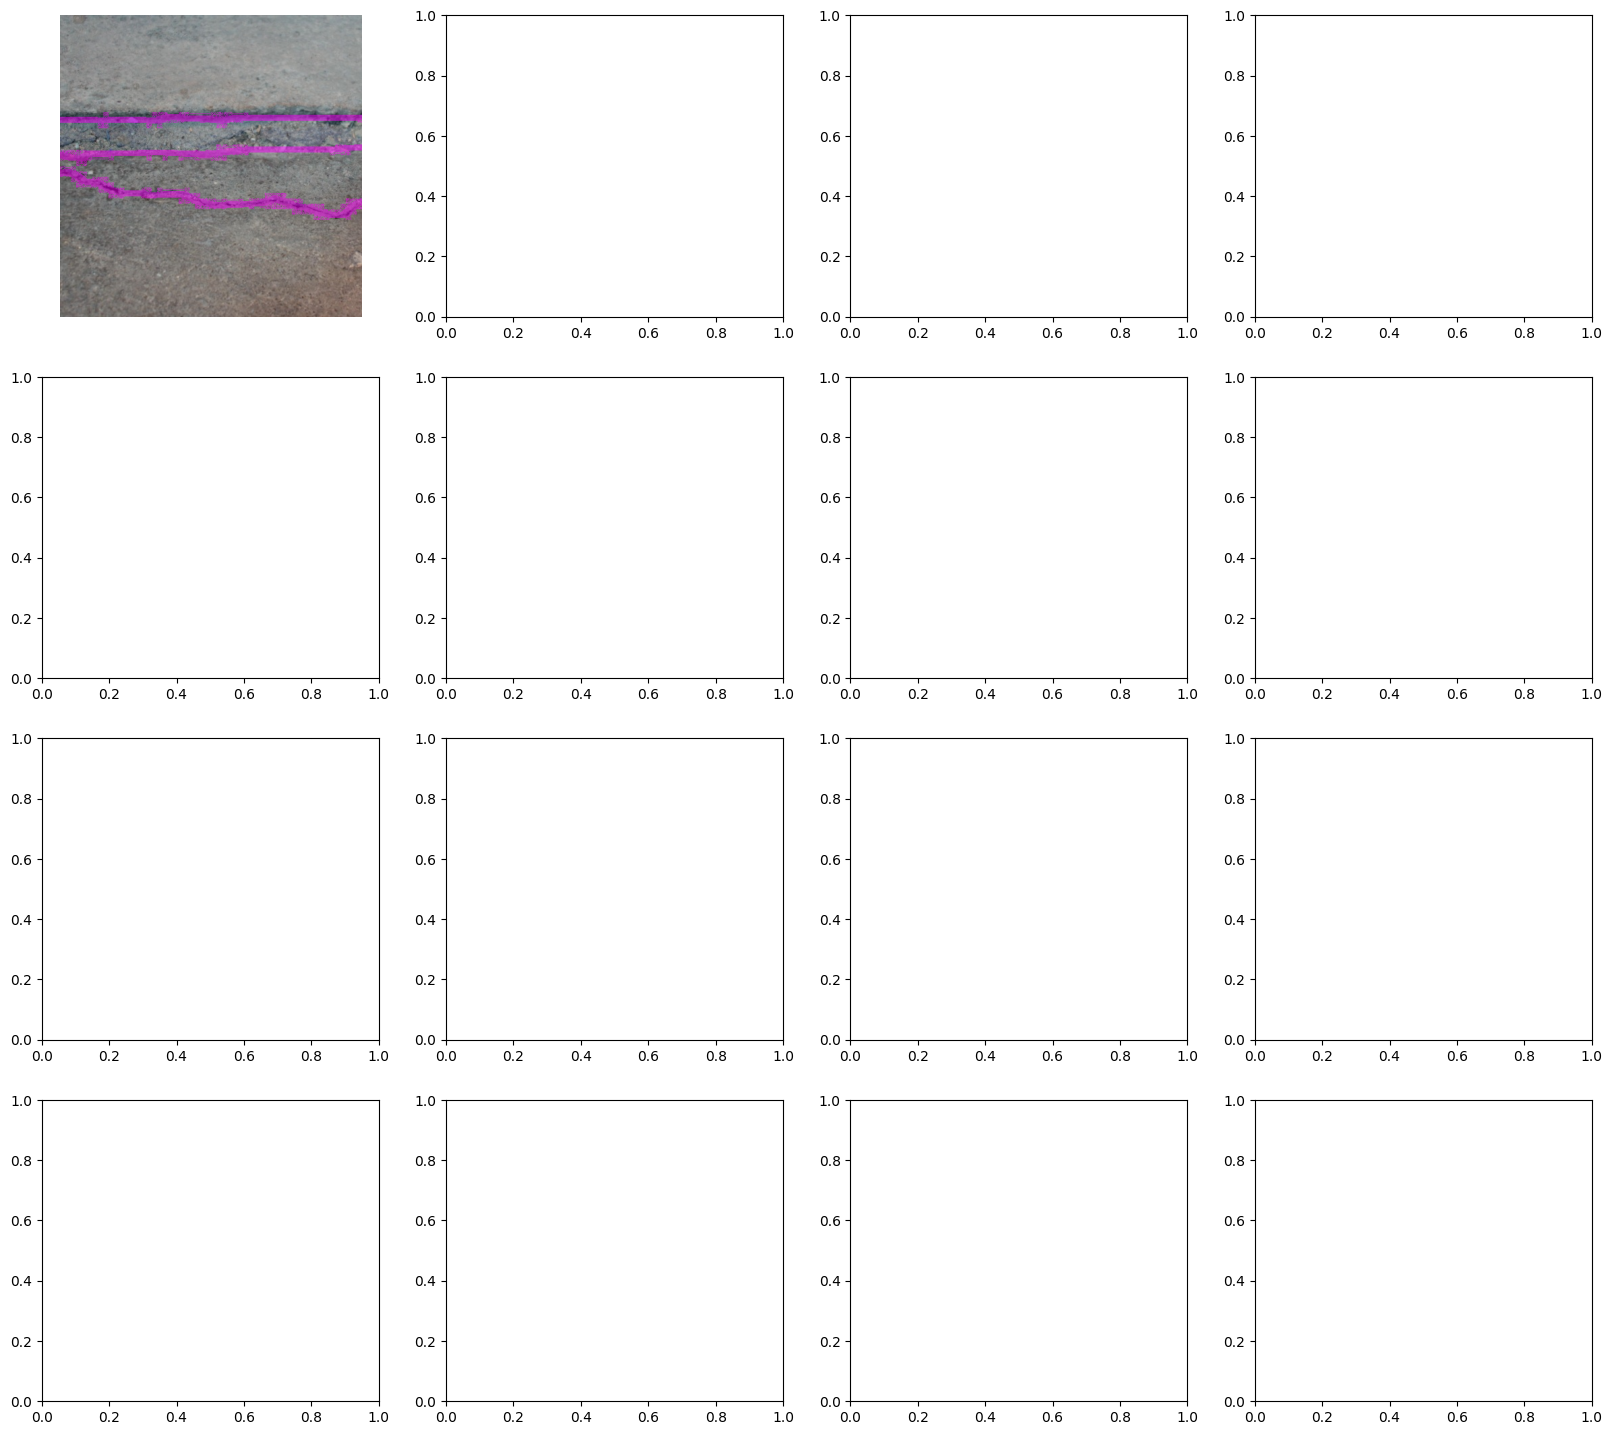

In [8]:
# Directories
images_dir = "Cracks_Image_Segmentation_Datasets/train/images"
images_mask = "Cracks_Image_Segmentation_Datasets/train/masks"
images = os.listdir(images_dir)

# Create a grid for visualization
fig, ax = plt.subplots(4, 4, figsize=(20, 18))
print(ax.shape)
ax = ax.ravel()
print(ax.shape)

# Define transparency level (0 to 1)
alpha = 0.5  # 50% transparency

# Define class names and their corresponding colors
class_names = ["Cracks"]
class_colors = {
    1: [255, 0, 255],
}

for i in range(16):
    # Randomly select an image
    img = random.choice(images)
    img_path = os.path.join(images_dir, img)
    mask_path = os.path.join(images_mask, img[:-4]+'.jpg')

    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load mask (grayscale)
    mask = cv2.imread(mask_path, 0)  # Single-channel grayscale mask

    mask[mask > 0] = 1  # Convert any non-zero values to 1

    blended_image = create_overlay_and_blend(image, mask, class_colors, alpha)

    # Display the segmented image
    ax[i].imshow(blended_image)
    ax[i].axis("off")  # Hide axis for better visualization

    # Save only the individual subplot
    extent = ax[i].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"img/subplot_001vdd{i}.png", bbox_inches=extent, dpi=300)


plt.tight_layout()
plt.show()

In [11]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Pretrained Model
model = models.deeplabv3_resnet50(weights="DEFAULT")  # Load pretrained weights
# print(model)

# Modify classifier for 2 classes (Background & Cracks)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))  # 2 output channels
# print(model)

# Remove auxiliary classifier (optional for inference)
model.aux_classifier = None
print(model)

# Move model to GPU if available
model = model.to(device)

print("Model is ready for binary segmentation (BG & Person).")


Using device: cpu


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 142MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
class CracksSegmentationDataset():
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform

        # Define class labels (only Background and Person)
        self.class_labels = {
            0: "Background",
            1: "Cracks"
        }

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Load image and convert to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask in grayscale mode
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Ensure mask values are either 0 (Background) or 1 (Cracks)
        mask = np.where(mask > 0, 1, 0).astype(np.uint8)

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']


        return image, torch.tensor(mask, dtype=torch.long)


In [13]:
import torchvision.models.segmentation as segmentation_models  # renamed for clarity
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the model
model = segmentation_models.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # 2 classes: background & crack

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import torchvision.models.segmentation as model
import torch.nn as nn
import torch
transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Directories
train_images_dir = "Cracks_Image_Segmentation_Datasets/train/images"
train_images_mask = "Cracks_Image_Segmentation_Datasets/train/masks"

val_images_dir = "Cracks_Image_Segmentation_Datasets/valid/images"
val_images_mask = "Cracks_Image_Segmentation_Datasets/valid/masks"

# Load dataset
train_dataset = CracksSegmentationDataset(train_images_dir, train_images_mask, transform=transform)
val_dataset = CracksSegmentationDataset(val_images_dir, val_images_mask, transform=transform)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


AttributeError: module 'torchvision.models.segmentation' has no attribute 'parameters'

In [15]:
print(len(train_loader))
print(len(val_loader))
print(len(val_dataset))
print(len(train_dataset))

188
24
187
1508


/tmp/ipython-input-12-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


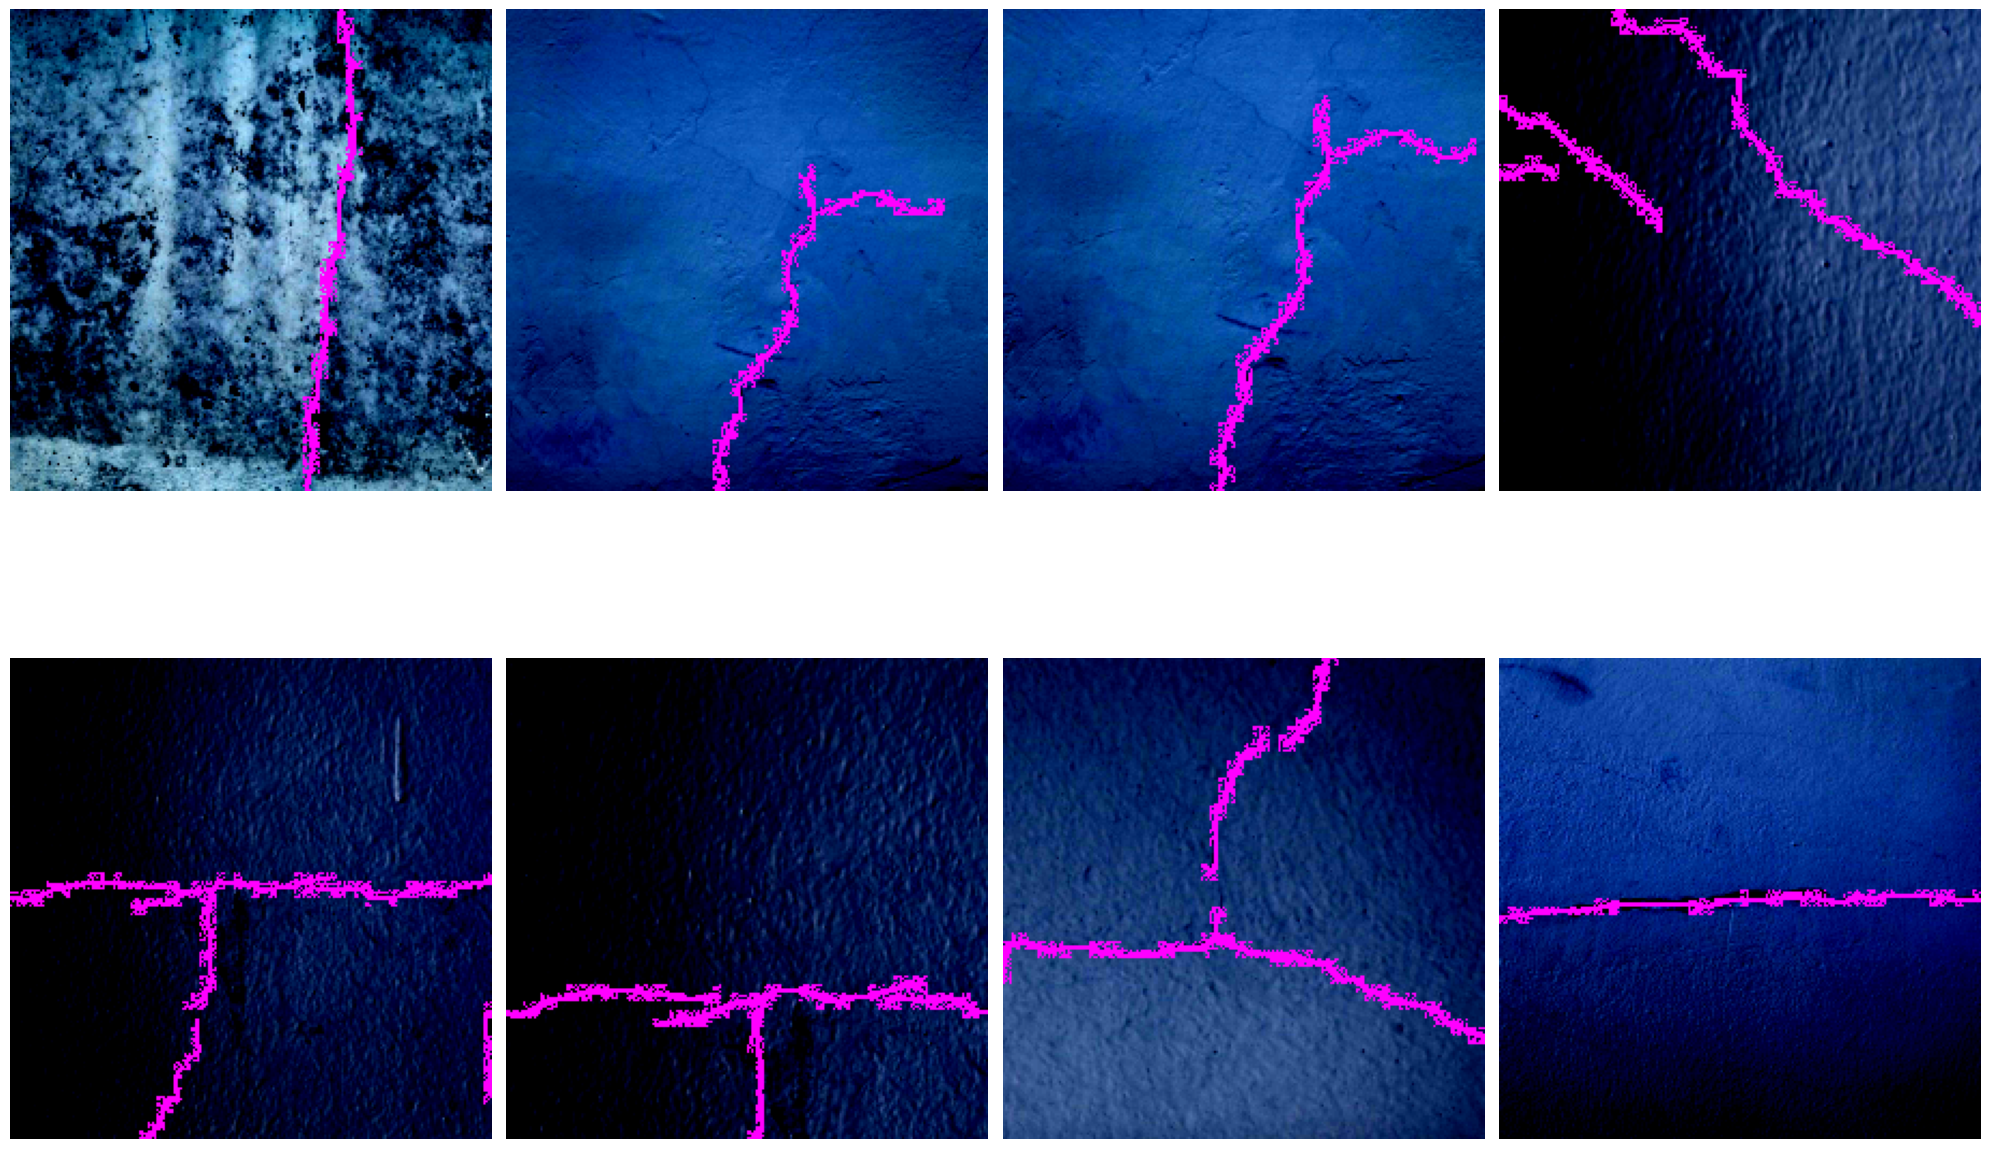

In [16]:
# Define transparency level (0 to 1)
alpha = 0.5 # 50% transparency

# Define class names and their corresponding colors
class_names = ["BG", "Cracks"]
class_colors = {
    1: [255, 0, 255],  # Yellow for Cracks
}

# Get a random batch from the DataLoader
random_batch_index = random.randint(0, len(val_loader) - 1)

# Iterate through the DataLoader to get the random batch
for batch_idx, (images, masks) in enumerate(val_loader):
    if batch_idx == random_batch_index:
        fig, ax = plt.subplots(2, 4, figsize=(20, 15))
        ax = ax.ravel()

        for i in range(8):
            image = images[i].permute(1, 2, 0).cpu().numpy()
            mask = masks[i].cpu().numpy()

            # mask[mask > 0] = 1

            blended_image = create_overlay_and_blend(image, mask, class_colors, alpha)

            ax[i].imshow(blended_image)
            ax[i].axis("off")

        plt.tight_layout()
        plt.show()
        break



In [17]:
import torchvision.models.segmentation as models
import torch.optim.lr_scheduler as lr_scheduler

model = models.fcn_resnet50(pretrained=False, num_classes=2)  # 2 for binary segmentation
# Define optimizer first
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Now define the scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


NameError: name 'EPOCHS' is not defined

***TRAINING WITH CPU !***

In [ ]:
import torch
from torch.optim import Adam, lr_scheduler

# Set device (CPU only training as per your environment)
device = torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Initialize best loss and lists to track performance
best_loss = float("inf")
save_path = "best_model.pth"

train_loss_list = []
val_loss_list = []

EPOCHS = 5

# Define CosineAnnealingLR scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

for epoch in range(EPOCHS):
    # --------------------
    # Training Phase
    # --------------------
    model.train()
    epoch_train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Compute loss
        loss = criterion(outputs, masks)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f"\n🚀 Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

    # --------------------
    # Validation Phase
    # --------------------
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            val_loss = criterion(outputs, masks)
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    print(f"🧪 Epoch [{epoch+1}/{EPOCHS}], Val Loss: {avg_val_loss:.4f}")

    # --------------------
    # Save the best model
    # --------------------
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved with val loss {best_loss:.4f}")

    # --------------------
    # Step the scheduler
    # --------------------
    scheduler.step()

print(f"🎉 Training complete! Best model saved at: {save_path}")


/tmp/ipython-input-12-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
/tmp/ipython-input-12-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


***TRAINING WITH CPU OR GPU !***



In [17]:
from torch.optim import lr_scheduler

# Initialize best loss as a large number
best_loss = float("inf")
save_path = "best_model.pth"  # Path to save the best model

# Track training and validation loss
train_loss_list = []
val_loss_list = []

EPOCHS = 5

# Define CosineAnnealingLR scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6) # 0.000001

for epoch in range(EPOCHS):
    # --------------------
    # Training Phase
    # --------------------
    model.train()
    epoch_train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Compute loss
        loss = criterion(outputs, masks)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)  # Store training loss
    print(f"\n🚀 Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

    # --------------------
    # Validation Phase
    # --------------------
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)['out']

            # Compute loss
            val_loss = criterion(outputs, masks)
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)  # Store validation loss
    print(f"🧪 Epoch [{epoch+1}/{EPOCHS}], Val Loss: {avg_val_loss:.4f}")

    # --------------------
    # Save the best model
    # --------------------
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved with val loss {best_loss:.4f}")

    # --------------------
    # Step the scheduler
    # --------------------
    scheduler.step()

print(f"🎉 Training complete! Best model saved at: {save_path}")


/tmp/ipython-input-9-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


KeyboardInterrupt: 

***TRAINING USING GPU !***



In [18]:
import torch
from torch.optim import Adam, lr_scheduler

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# Move model to GPU if available
model = model.to(device)

# Optimizer and Loss
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# DataLoader improvements
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# Initialize best loss as a large number
best_loss = float("inf")
save_path = "best_model.pth"  # Path to save the best model

# Track training and validation loss
train_loss_list = []
val_loss_list = []

EPOCHS = 25

# Define CosineAnnealingLR scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6) # 0.000001

for epoch in range(EPOCHS):
    # --------------------
    # Training Phase
    # --------------------
    model.train()
    epoch_train_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Compute loss
        loss = criterion(outputs, masks)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)  # Store training loss
    print(f"\n🚀 Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}")

    # --------------------
    # Validation Phase
    # --------------------
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)['out']

            # Compute loss
            val_loss = criterion(outputs, masks)
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)  # Store validation loss
    print(f"🧪 Epoch [{epoch+1}/{EPOCHS}], Val Loss: {avg_val_loss:.4f}")

    # --------------------
    # Save the best model
    # --------------------
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Model saved with val loss {best_loss:.4f}")

    # --------------------
    # Step the scheduler
    # --------------------
    scheduler.step()

print(f"\n🎉 Training complete! Best model saved at: {save_path}")


🚀 Using device: cpu


/tmp/ipython-input-12-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
/tmp/ipython-input-12-3726688774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


KeyboardInterrupt: 

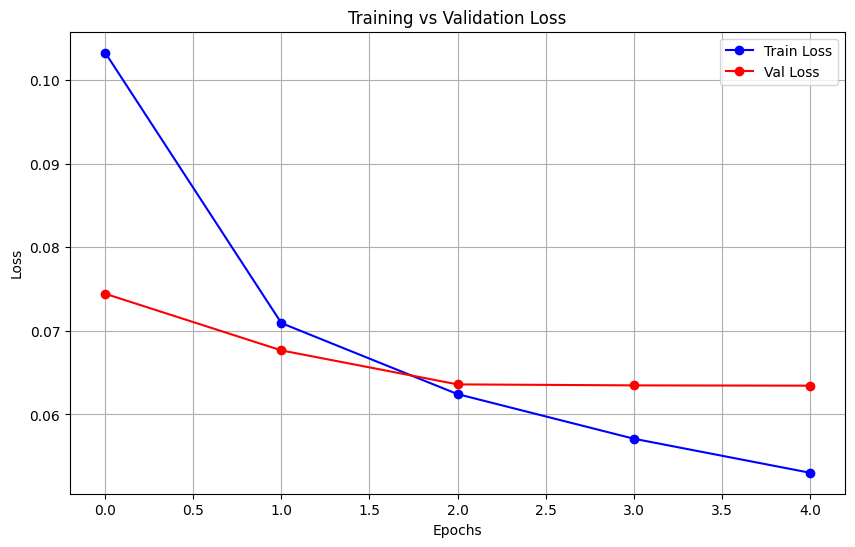

In [19]:
# Plot train and val loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label="Train Loss", marker="o", color="blue")
plt.plot(val_loss_list, label="Val Loss", marker="o", color="red")

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)  # Add grid for better visualization

# Show plot
plt.show()


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


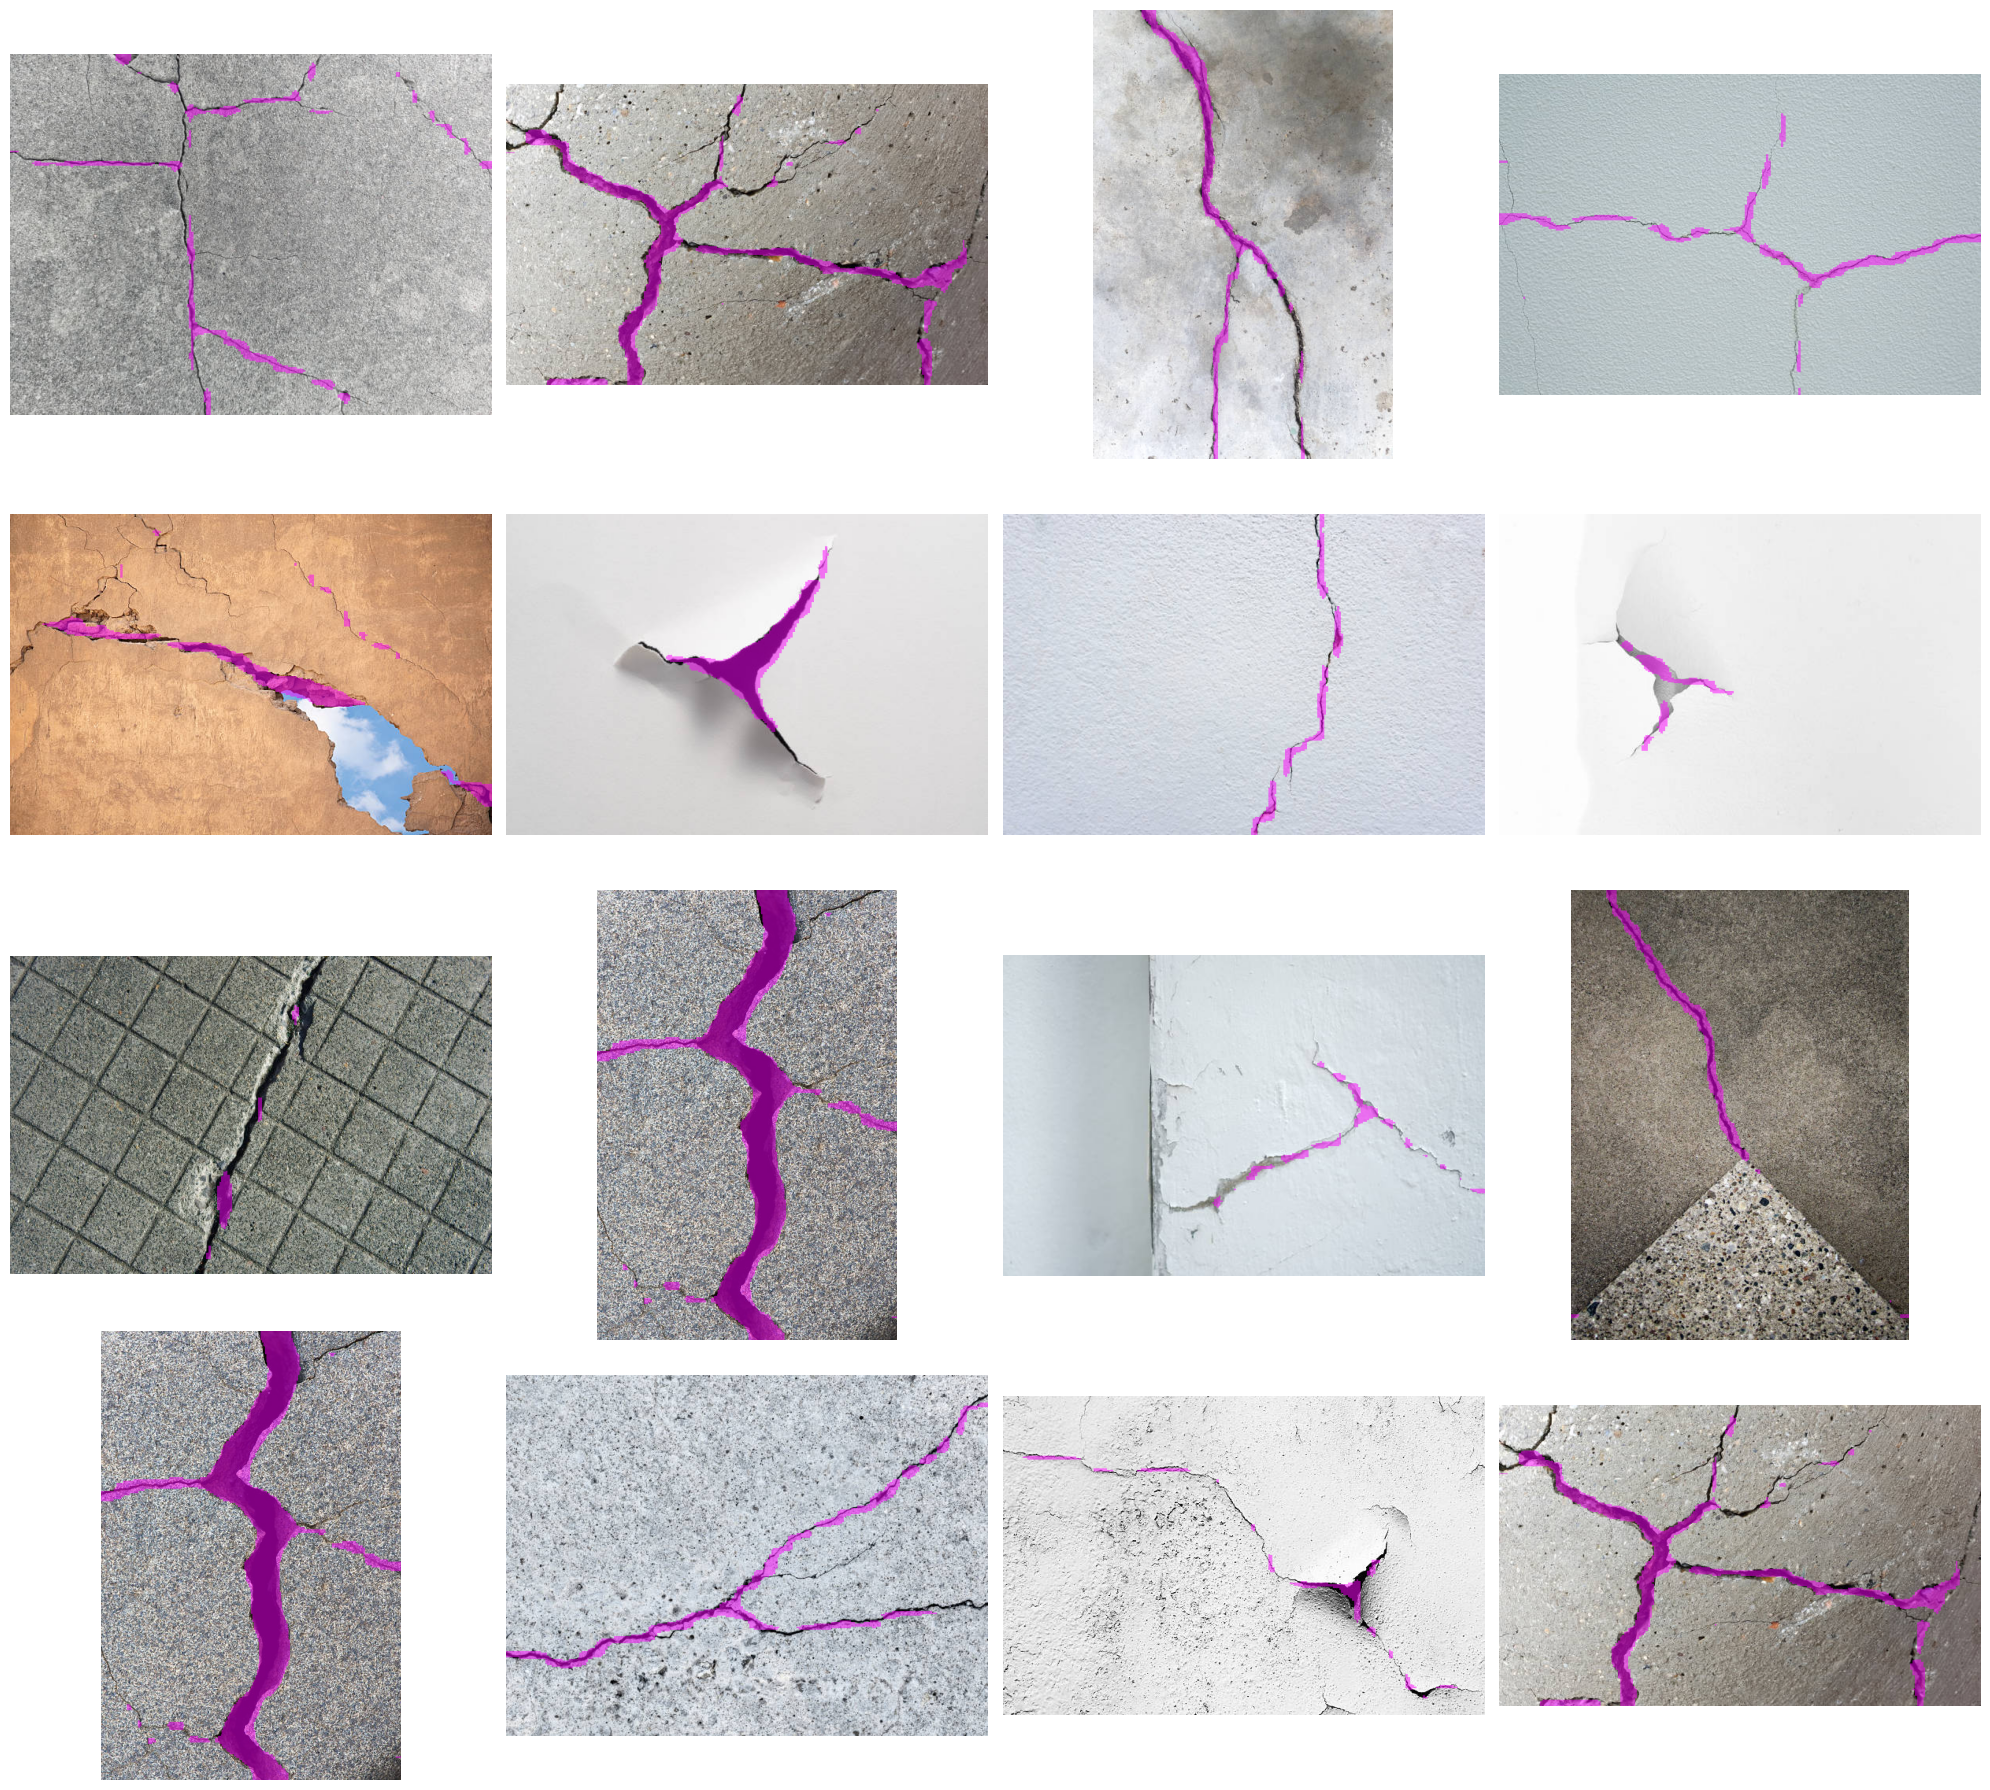

In [ ]:
import cv2
import random
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models
from PIL import Image

# Load the trained model
model_path = "best_model.pth"  # Path to your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and set to evaluation mode
model = models.segmentation.deeplabv3_resnet50(pretrained=False, num_classes=2)  # 2 classes: Background & Cracks
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Directories
images_dir = "Cracks_Image_Segmentation_Datasets/test"
images = os.listdir(images_dir)

# Create a grid for visualization
fig, ax = plt.subplots(4, 4, figsize=(20, 18))
ax = ax.ravel()

# Define transparency level (0 to 1)
alpha = 0.5  # 50% transparency

# Class definitions (Only Background & Cracks)
class_names = ["Background", "Cracks"]
class_colors = {
    0: [0, 0, 0],      # Background (Black)
    1: [255, 0, 255]   # Cracks (Pink)
}

# ✅ Fixed: Correct preprocessing order
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),  # Convert PIL to Tensor FIRST ✅
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize AFTER ToTensor ✅
])

for i in range(16):
    # Randomly select an image
    img = random.choice(images)
    img_path = os.path.join(images_dir, img)

    # Load image and convert to RGB
    image = Image.open(img_path).convert("RGB")  # ✅ Ensure RGB format

    # Apply model transformations
    input_tensor = transform(image).unsqueeze(0).to(device)  # ✅ Now correctly formatted

    # Model Prediction
    with torch.no_grad():
        output = model(input_tensor)['out'][0]  # Get model output

    predicted_mask = torch.argmax(output, dim=0).cpu().numpy()

    # ✅ Fixed: Convert PIL image to NumPy before resizing
    image_np = np.array(image)  # Convert PIL to NumPy

    # ✅ Fixed: Use `.size` instead of `.shape` for PIL
    original_width, original_height = image.size

    # Resize predicted mask to match original image size
    mask = cv2.resize(predicted_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    blended_image = create_overlay_and_blend(image_np, mask, class_colors, alpha)

    # Display the segmented image
    ax[i].imshow(blended_image)
    ax[i].axis("off")  # Hide axis for better visualization

    # Save only the individual subplot
    extent = ax[i].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"img/subplot_001vdd{i}.png", bbox_inches=extent, dpi=300)

# Plot and show final grid
plt.tight_layout()
plt.show()
